## import necessary libraries

In [1]:
import pandas as pd # table operations
import numpy as np # matrix computations
import matplotlib.pyplot as plt # vizualizing
import glob
import os
import seaborn as sns
import tensorflow as tf
import cv2
from tensorflow.python.client import device_lib # inspect devices
from warnings import filterwarnings
filterwarnings("ignore") # ignore unnecessary warnings

In [2]:
# check devices
device_lib.list_local_devices()

2022-04-26 14:39:56.494018: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-26 14:39:56.531886: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 14:39:56.541945: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 14:39:56.542685: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3417945196659792312,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16152002560
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16374531236419510765
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

## Define constants

In [3]:
batch_size = 64
epochs = 40
img_channel = 3
img_width, img_height = (150,150)
train_dataset_main = "../input/mma-facial-expression/MMAFEDB/train"
test_dataset_main = "../input/mma-facial-expression/MMAFEDB/test"
valid_dataset_main = "../input/mma-facial-expression/MMAFEDB/valid"

## Prepare datasets

In [4]:
def create_dataset_df(main_path, dataset_name):
    print(f"{dataset_name} is creating ...")
    df = {"img_path":[],"class_names":[]}
    for class_names in os.listdir(main_path):
            for img_path in glob.glob(f"{main_path}/{class_names}/*"):
                df["img_path"].append(img_path)
                df["class_names"].append(class_names)
    df = pd.DataFrame(df)
    print(f"{dataset_name} is created !")
    return df

In [5]:
train_df = create_dataset_df(train_dataset_main, "Train dataset")

Train dataset is creating ...
Train dataset is created !


In [6]:
test_df = create_dataset_df(test_dataset_main, "Test dataset")

Test dataset is creating ...
Test dataset is created !


In [7]:
valid_df = create_dataset_df(valid_dataset_main, "Valid dataset")

Valid dataset is creating ...
Valid dataset is created !


In [8]:
train_df.head()

,img_path,class_names
0,../input/mma-facial-expression/MMAFEDB/train/s...,surprise
1,../input/mma-facial-expression/MMAFEDB/train/s...,surprise
2,../input/mma-facial-expression/MMAFEDB/train/s...,surprise
3,../input/mma-facial-expression/MMAFEDB/train/s...,surprise
4,../input/mma-facial-expression/MMAFEDB/train/s...,surprise


In [9]:
f"train samples: {len(train_df)} \n validation samples: {len(valid_df)} \n test samples: {len(test_df)}"

'train samples: 92968 \n validation samples: 17356 \n test samples: 17356'

## Vizualizing

In [10]:
def vizualizing_images(df,n_rows,n_cols):
    plt.figure(figsize=(10,10))
    for i in range(n_rows*n_cols):
        index = np.random.randint(0, len(df))
        img = cv2.imread(df.img_path[index])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        class_nm = df.class_names[index]
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(img, plt.cm.gray)
        plt.title(class_nm)
    plt.show()

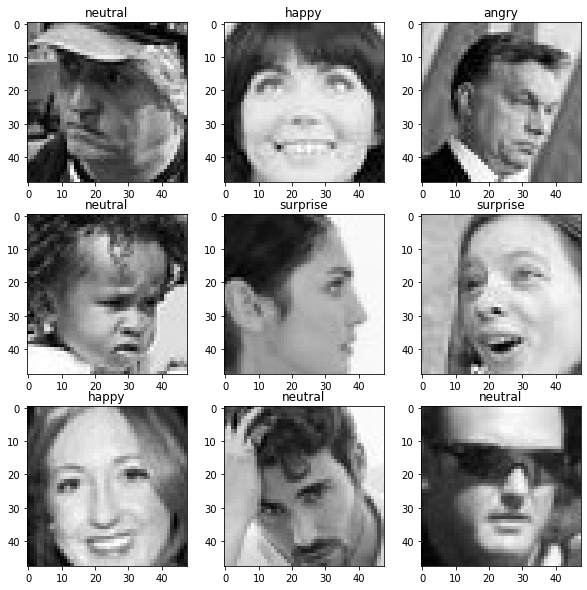

In [11]:
vizualizing_images(train_df, 3, 3)

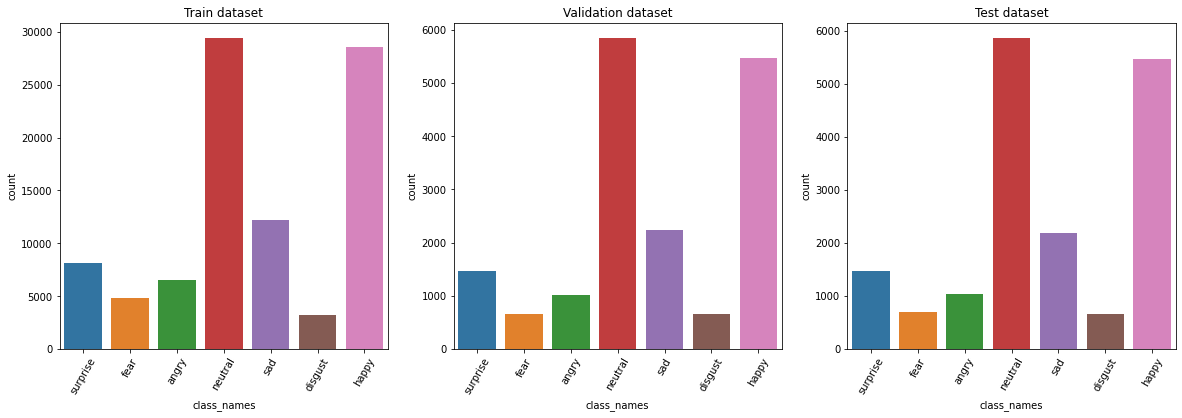

In [12]:
plt.figure(figsize=(20,6))
# train dataset
plt.subplot(1,3,1)
sns.countplot(train_df.class_names)
plt.title("Train dataset")
plt.xticks(rotation = 60)
# validation dataset
plt.subplot(1,3,2)
sns.countplot(valid_df.class_names)
plt.title("Validation dataset")
plt.xticks(rotation = 60)

# test dataset
plt.subplot(1,3,3)
sns.countplot(test_df.class_names)
plt.title("Test dataset")
plt.xticks(rotation = 60)

plt.show()

## Data Generator

In [13]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [14]:
train_gen = data_gen.flow_from_dataframe(
 train_df,
    batch_size = 64,
  x_col='img_path',
    y_col='class_names',
    target_size = (img_width,img_height),
     shuffle=True,
    color_mode = "rgb",
    class_mode="categorical",

)

Found 92968 validated image filenames belonging to 7 classes.


In [15]:
valid_gen = data_gen.flow_from_dataframe(
 valid_df,
        batch_size = 64,

  x_col='img_path',
    y_col='class_names',
    target_size = (img_width,img_height),
     shuffle=False,
    color_mode = "rgb",
class_mode="categorical"
)

Found 17356 validated image filenames belonging to 7 classes.


In [16]:
test_gen = data_gen.flow_from_dataframe(
 test_df,
        batch_size = 64,

  x_col='img_path',
    y_col='class_names',
    target_size = (img_width,img_height),
     shuffle=False,
    color_mode = "rgb",
class_mode="categorical"
)

Found 17356 validated image filenames belonging to 7 classes.


## Create Model with transfer learning

In [17]:
def vgg16_model( num_classes=None):

    model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, img_channel))
    for layer in model.layers[1:-1]:
        layer.trainable = False
    x=tf.keras.layers.Flatten()(model.output)
    x=tf.keras.layers.Dense(12,activation='relu')(x) 
    output=tf.keras.layers.Dense(num_classes,activation='softmax')(x) 
    model=tf.keras.models.Model(model.input,output)
    
    return model

model=vgg16_model(num_classes = 7)

2022-04-26 14:40:30.091321: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 14:40:30.092281: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 14:40:30.093085: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 14:40:30.093996: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 14:40:30.094710: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## Train the model

In [19]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [20]:
model.fit_generator( train_gen,
    steps_per_epoch = train_gen.samples // batch_size,
    validation_data = valid_gen, 
    validation_steps = valid_gen.samples // batch_size,
    epochs = epochs)

2022-04-26 14:40:31.046137: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2022-04-26 14:40:31.975878: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1452/1452 [==============================] - 133s 89ms/step - loss: 1.3623 - accuracy: 0.5141 - val_loss: 1.4994 - val_accuracy: 0.4515
Epoch 2/40
1452/1452 [==============================] - 123s 85ms/step - loss: 1.2418 - accuracy: 0.5597 - val_loss: 1.4874 - val_accuracy: 0.4545
Epoch 3/40
1452/1452 [==============================] - 124s 85ms/step - loss: 1.2040 - accuracy: 0.5710 - val_loss: 1.5083 - val_accuracy: 0.4591
Epoch 4/40
1452/1452 [==============================] - 122s 84ms/step - loss: 1.1754 - accuracy: 0.5820 - val_loss: 1.4982 - val_accuracy: 0.4671
Epoch 5/40
1452/1452 [==============================] - 128s 88ms/step - loss: 1.1552 - accuracy: 0.5907 - val_loss: 1.4863 - val_accuracy: 0.4613
Epoch 6/40
1452/1452 [==============================] - 129s 89ms/step - loss: 1.1420 - accuracy: 0.5933 - val_loss: 1.4977 - val_accuracy: 0.4624
Epoch 7/40
1452/1452 [==============================] - 131s 90ms/step - loss: 1.1296 - accuracy: 0.5989 - val_loss: 1.5251 - val

## Trainining  results vizualization

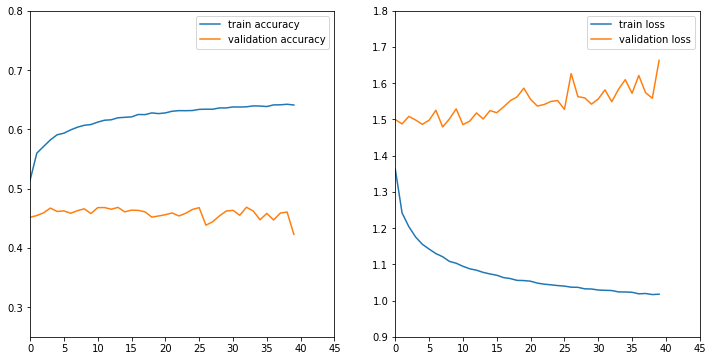

In [27]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.plot(model.history.history["accuracy"],label = "train accuracy")
plt.plot(model.history.history["val_accuracy"],label = "validation accuracy")
plt.legend()
plt.ylim(0.25,0.8)
plt.xlim(0,45)
plt.subplot(1,2,2)
plt.plot(model.history.history["loss"],label = "train loss")
plt.plot(model.history.history["val_loss"],label = "validation loss")
plt.ylim(0.9,1.8)
plt.xlim(0,45)

plt.legend()

plt.show()

In [38]:
# save model
model.save("classify_model.h5")

## Prediction

In [28]:
preds = model.predict_generator(test_gen,verbose=1)

272/272 [==============================] - 107s 392ms/step


In [35]:
preds

array([[1.30184565e-03, 2.04088341e-04, 3.98435950e-01, ...,
        3.07456916e-03, 1.41070541e-02, 5.82542241e-01],
       [1.18185826e-01, 1.09724086e-02, 2.10134029e-01, ...,
        3.08714602e-02, 1.30260196e-02, 6.06158316e-01],
       [6.44643093e-03, 3.43763706e-04, 8.37631047e-01, ...,
        3.58107034e-03, 8.97904634e-02, 6.20936416e-02],
       ...,
       [5.05334930e-03, 7.13220472e-03, 1.80078519e-03, ...,
        3.49735804e-02, 5.05682779e-03, 7.66653055e-03],
       [2.69669434e-03, 2.28734985e-02, 2.50463909e-03, ...,
        7.62288630e-01, 1.79500759e-01, 2.99016549e-03],
       [1.27622709e-01, 1.96430981e-02, 3.30255851e-02, ...,
        3.33552547e-02, 1.65480841e-03, 7.46892571e-01]], dtype=float32)

In [45]:
pred_argmaxed = preds.argmax(axis=1)

In [65]:
from sklearn.metrics import classification_report
print(classification_report(test_gen.labels,pred_argmaxed))

              precision    recall  f1-score   support

           0       0.27      0.51      0.35      1041
           1       0.00      0.00      0.00       655
           2       0.19      0.30      0.23       691
           3       0.69      0.40      0.51      5459
           4       0.50      0.65      0.56      5858
           5       0.29      0.25      0.27      2177
           6       0.39      0.41      0.40      1475

    accuracy                           0.46     17356
   macro avg       0.33      0.36      0.33     17356
weighted avg       0.48      0.46      0.45     17356



In [87]:
train_gen.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [89]:
!rm "./classify_model.h5"